In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import torch.nn.functional as F
from torch.optim import Adam
from tqdm.auto import trange
import torch.nn as nn
from glob import glob
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from dgl.dataloading import GraphDataLoader

from cloudmanufacturing.data import read_fatahi_dataset
from cloudmanufacturing.graph import dglgraph, graph_gamma, os_type, so_type, ss_type
from cloudmanufacturing.graphconv import GNN
from cloudmanufacturing.solvers.mip_solver import mip_solve
from cloudmanufacturing.validation import construct_delta, objvalue, construct_delta2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

c:\Users\z004w9ze\AppData\Local\miniconda3\envs\graph\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cpu')

In [2]:
dataset = read_fatahi_dataset("../data/train_data.xlsx")

100%|██████████| 100/100 [02:22<00:00,  1.43s/it]


In [3]:
def dglgraph_fixed(graph, oper_max=20):
        ncolumns = graph.ndata['feat']['o'].shape[1]
        graph.ndata['feat'] = {'o': F.pad(graph.ndata['feat']['o'], [0, oper_max - ncolumns])}
        return graph

In [4]:
class GraphDataset(Dataset):
    def __init__(self, problems, gammas, deltas):
        self.problems = problems
        self.gammas = gammas
        self.deltas = deltas

    def __len__(self):
        return len(self.problems)

    def __getitem__(self, idx):
        problem = self.problems[idx]
        gamma = self.gammas[idx]
        delta = self.deltas[idx]
        graph = dglgraph(problem, gamma, delta).to(device)
        graph = dglgraph_fixed(graph)
        # graph.edata["feat"][os_type][:, 0] /= 10
        # graph.edata["feat"][ss_type] /= 100
        return graph

In [5]:
info = {}
for delta, gamma, idx in zip([i for i in glob('train_solutions/*') if 'delta' in i],
                             [i for i in glob('train_solutions/*') if 'gamma' in i],
                             [int(i.split('_')[-2]) for i in glob('train_solutions/*') if 'gamma' in i]):
    if idx < 20:
        info[idx] = {}
        info[idx]['gamma'] = np.load(gamma)
        info[idx]['delta'] = np.load(delta)
        info[idx]['problem'] = dataset[idx]

In [6]:
train_idx, test_idx = train_test_split(list(info.keys()),
                                       random_state=42,train_size=0.7)

In [7]:
train_dataset = GraphDataset([info[i]['problem'] for i in train_idx],
                             [info[i]['gamma'] for i in train_idx],
                             [info[i]['delta'] for i in train_idx])

test_dataset = GraphDataset([info[i]['problem'] for i in test_idx],
                            [info[i]['gamma'] for i in test_idx],
                            [info[i]['delta'] for i in test_idx])

In [8]:
train_loader = GraphDataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = GraphDataLoader(test_dataset, batch_size=2, shuffle=True)

In [9]:
def validate_objective(model, dataset):
    test_objvalue = []
    for i in range(len(dataset.problems)):
        pred_gamma, pred_delta = model.predict(dataset.__getitem__(i), dataset.problems[i])
        test_objvalue.append(
            objvalue(dataset.problems[i], pred_gamma, pred_delta)
        )
    return np.mean(test_objvalue)

In [10]:
def plot_loss(losses_info):
    keys = [key for key in losses_info.keys() if 'loss' in key]
    for key in keys:
        plt.plot(losses_info[key], label=key)
        print(f'min {key} loss: ', min(losses_info[key]))
        plt.legend()
    plt.show()

def plot_objvalue(losses_info):
    keys = [key for key in losses_info.keys() if 'objvalue' in key]
    for key in keys:
        plt.plot(losses_info[key], label=key)
        plt.legend()
        print(f'min {key} objvalue: ', min(losses_info[key]))
    plt.show()

def print_info(info):
    plot_loss(info)
    plot_objvalue(info)

In [11]:
model = GNN(s_shape=1, o_shape=20, os_shape=2,
            ss_shape=10, out_dim=16, n_layers=1).to(device)

optim = Adam(model.parameters(), lr=1e-4)

In [12]:
i=0
gamma = info[i]['gamma']
delta = info[i]['delta']
problem = dataset[i]

print(problem['operations'])
print(gamma.sum())
print(delta.sum())

[[0. 1. 0. 1. 1.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 1.]
 [1. 0. 1. 0. 1.]
 [1. 0. 0. 1. 1.]
 [0. 0. 1. 1. 0.]
 [1. 1. 0. 0. 0.]]
20.0
20.0


In [14]:
np.nonzero(delta)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int64),
 array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int64),
 array([4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 9, 9],
       dtype=int64),
 array([2, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 2, 3, 0, 1],
       dtype=int64))

In [15]:
np.nonzero(gamma)

(array([0, 0, 0, 1, 2, 3, 3, 4, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 9, 9],
       dtype=int64),
 array([1, 3, 4, 2, 0, 0, 1, 2, 1, 4, 0, 2, 4, 0, 3, 4, 2, 3, 0, 1],
       dtype=int64),
 array([4, 2, 1, 8, 0, 0, 4, 8, 4, 1, 0, 8, 1, 0, 2, 1, 8, 2, 0, 0],
       dtype=int64))

In [13]:
idx=0
gamma = info[idx]['gamma']
delta = info[idx]['delta']
for op_num in range(dataset[idx]['operations'].shape[1]):
    print('task:', op_num)
    city_list = []
    for i, sub_op in enumerate(np.nonzero(dataset[idx]['operations'][:,op_num])[0]):
        c = np.nonzero(gamma[sub_op, op_num,:])
        city_list.append(c)
        if i != 0:
            print(city_list[i-1][0], c[0])
            print(delta[:,city_list[i-1],c,sub_op,op_num].reshape(-1))
    print('\n')

task: 0
[0] [0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0] [0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0] [0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0] [0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


task: 1
[4] [4]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[4] [4]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[4] [0]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


task: 2
[8] [8]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[8] [8]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[8] [8]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


task: 3
[2] [2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[2] [2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


task: 4
[1] [1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1] [1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1] [1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]




In [17]:
loss_list_train = []
objvalue_train = []
loss_list_test = []
objvalue_test = []
for epoch in trange(50):
        ep_loss_train = []
        ep_loss_test = []
        for graph in train_loader:
            optim.zero_grad()
            # take initial info
            gamma_target = graph.edata["target"][os_type]
            delta_target = graph.edata["delta_target"][ss_type]
            mask = graph.edata["mask"][ss_type]
            # Forward pass
            logits, delta_logits = model(graph)
            # loss calculation
            operation_loss = F.binary_cross_entropy_with_logits(logits, gamma_target)
            service_loss = F.cross_entropy(delta_logits[mask], delta_target[mask])
            loss = operation_loss + service_loss
            loss.backward()
            optim.step()
            ep_loss_train.append(loss.item())

        for graph in test_loader:
            with torch.no_grad():
                # take initial info
                gamma_target = graph.edata["target"][os_type]
                delta_target = graph.edata["delta_target"][ss_type]
                mask = graph.edata["mask"][ss_type]
                # Forward pass
                logits, delta_logits = model(graph)
                # loss calculation
                operation_loss = F.binary_cross_entropy_with_logits(logits, gamma_target)
                service_loss = F.cross_entropy(delta_logits[mask], delta_target[mask])
                loss = operation_loss + service_loss*0.2
                ep_loss_test.append(loss.item())

        loss_list_train.append(np.mean(ep_loss_train))
        loss_list_test.append(np.mean(ep_loss_test))

        if (epoch + 1) % 10 == 0:
            objvalue_train.append(validate_objective(model, train_dataset))
            objvalue_test.append(validate_objective(model, test_dataset))

100%|██████████| 50/50 [01:50<00:00,  2.21s/it]


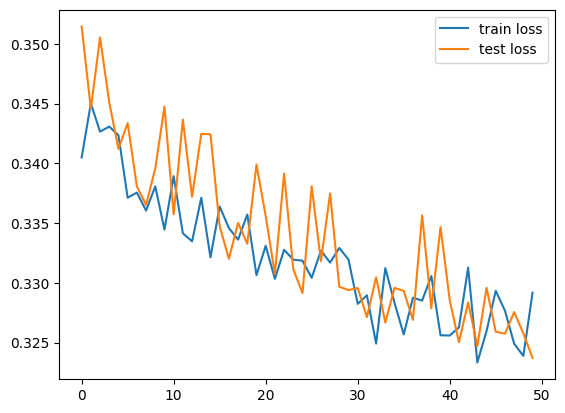

In [18]:
plt.plot(loss_list_train, label='train loss')
plt.plot(loss_list_test, label='test loss')
plt.legend()
plt.show()

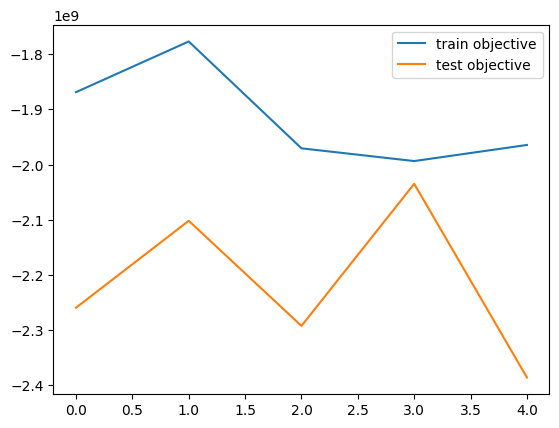

In [19]:
plt.plot(objvalue_train, label='train objective')
plt.plot(objvalue_test, label='test objective')
plt.legend()
plt.show()

In [ ]:
def train_model(graph_loader, dataset, model, num_epoch,
                info={}, suffix='train', train=True):
    loss_list = []
    objvalue = []
    for epoch in range(num_epoch):
        ep_loss = []
        for graph in graph_loader:
            optim.zero_grad()
            # take initial info
            gamma_target = graph.edata["target"][os_type]
            delta_target = graph.edata["delta_target"][ss_type]
            mask = graph.edata["mask"][ss_type]
            # Forward pass
            logits, delta_logits = model(graph)
            # loss calculation
            operation_loss = F.binary_cross_entropy_with_logits(logits, gamma_target)
            service_loss = F.cross_entropy(delta_logits[mask], delta_target[mask])
            loss = operation_loss + service_loss
            loss.backward()
            optim.step()
            ep_loss.append(loss.item())
        loss_list.append(np.mean(ep_loss))
        

        if (epoch + 1) % 10 == 0:
            objvalue.append(validate_objective(model, dataset))
    info[f'{suffix}_loss'] = loss_list
    info[f'{suffix}_objvalue'] = objvalue
    return info

In [ ]:
for i in trange(15):
    model.train()
    info = train_model(train_loader, train_dataset, model, 10)
    model.eval()
    with torch.no_grad():
        info = train_model(test_loader, test_dataset, model, 10,
                        info=info, suffix='test', train=False)

In [ ]:
print_info(info)

In [50]:
# problem = dataset[0]
# a = generate_tariff_matrix(problem['n_services'],
#                        problem['dist'],
#                        problem['productivity']/100,
#                        problem['op_cost'])